In [41]:
import gc, os
import pickle
import cfgrib
import pygrib

import pandas as pd
import numpy as np
import xarray as xr
import multiprocessing as mp
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from glob import glob
from datetime import datetime, timedelta
from functools import partial, reduce

import warnings
warnings.filterwarnings('ignore')

os.environ['OMP_NUM_THREADS'] = '1'

In [42]:
svr_model_config = 'all'
site, interval, delay = 'CLNX', 12, 12
site_lat, site_lon = 40.5763, -111.6383

model = 'gfs0p25'

temp = '/scratch/general/lustre/u1070830/binary_temp/'; os.makedirs(temp, exist_ok=True)
archive = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/archive/'

obs_dir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/clean/'

date_fmt = '%Y%m%d'
datetime_fmt = '%Y%m%d%H'

In [43]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [44]:
def svr(X, config='all'):
    
    mlmodel_dir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/output/slr_models/%s/'%svr_model_config
    
    scaler_file = glob(mlmodel_dir + '*scaler*')[-1]
    stats_file = glob(mlmodel_dir + '*train_stats*')[-1]
    model_file = glob(mlmodel_dir + '*SLRmodel*')[-1]
    
    with open(scaler_file, 'rb') as rfp:
        scaler = pickle.load(rfp)

    with open(stats_file, 'rb') as rfp:
        train_stats, train_stats_norm = pickle.load(rfp)
        model_keys = train_stats.keys()

    with open(model_file, 'rb') as rfp:
        SLRmodel = pickle.load(rfp)
                
    X_trim = pd.DataFrame(X[model_keys]).T
    
    X_norm = pd.DataFrame(scaler.transform(X_trim), index=X_trim.index, columns=X_trim.keys())
    
    return SLRmodel.predict(X_norm)

In [45]:
def ratio(X, units=None):
    return 10

In [46]:
def nwstable(X, tvar='T2M', units='K'):
    
    x = X[tvar]
    
    x = x if units == 'C' else x-273.15
    
    if x > 1.5:
        return 0
    elif (-2.5 < x <= 1.5):
        return 10
    elif (-7.5 < x <= -2.5):
        return 15
    elif (-10 < x <= -7.5):
        return 20
    elif (-12.5 < x <= -10):
        return 30
    elif x <= -12.5:
        return 40
    else:
        return np.nan

In [47]:
def hrrr_asnow(X, tvar='T2M', units='K'):
    
    x = X[tvar]
    
    x = x if units == 'C' else x-273.15
    return 100/np.min([250, 100. / np.max([4.179, (13.*np.tanh((274.15-(x+273.15))/3.))])])

In [48]:
def kuchera(X, tvar='T2M', units='K'):
    
    x = X[tvar]
    
    x = x if units == 'K' else x+273.15
    
    if x > 271.16:
        return (12. + 2.*(271.16-x))
    elif x <= 271.16:
        return (12 + (271.16-x))
    else:
        return np.nan

In [49]:
def alcott(X, exclude=None):
    
    predset = [
        [X['T_650'], -3.31],
        [X['SPD_600']**2, -1.73e-2],
        [X['swe_mm'], 1.26],
        [X['V_400'], 5.91e-2],
        [(X['T_600'])**3, 3.33e-3],
        [(X['T_800'])**3, 4.38e-3],
        [1/(X['T_600']), -243],
        [X['R_550'], 6.16e-6], 
        [((X['R_750'] + X['R_700'])/2), -0.136],
        [X['R_850'], 6.91e-6],
        [X['DIR_700'], 1.27e-2],
        [abs(310.-X['DIR_700']), 1.76e-2], # Direction index, a deviation from 310
        [(X['T_500'])**2, 2.16e-3],
        [(X['T_500'])**3, 2.16e-3],
        [(X['T_550'])**3, -2.11e-3], 
        [X['SPD_400'], -5.28e-2],
        [X['SPD_600'], 0.342],]
    
    if exclude:
        del predset[exclude]
            
    return np.sum([np.prod(i) for i in predset])

def alcott_hiswe(X, exclude=None):
    
    predset = [
        [(X['T_550']), -0.489],
        [X['SPD_600']**2, -1.61e-2],
        [((X['T_750'] + X['T_700'])/2), -0.936],
        [X['V_650'], 0.215],
        [X['T_400'], 0.396],
        [1/(X['T_850']), -0.151],
        [abs(310.-X['DIR_850']), -2.05e-2],  # Direction indeX, a deviation from 310
        [X['R_450'], 1.02e-5], 
        [((X['R_850'] + X['R_800'])/2), -3.76e-6],]
    
    if exclude:
        del predset[exclude]
    
    return np.sum([np.prod(i) for i in predset])

In [50]:
def web_slr_only(X, wbzh=0, orog=0):
    
    tlayer = np.mean([X['T_400'], X['T_500'], X['T_600'], X['T_700'], X['T_800']])
    
    # Tunable transition layer parameters (m)
    all_snow_buffer = 0
    transition_layer = 200
    
    # Extend the snow level below the wet bulb zero parameter height if set
    snow_level = wbzh - all_snow_buffer
    snow_level = xr.where(snow_level < 0., 0., snow_level)

    # Curve fit to Alcott and Steenburgh (2010) SMLR results
    init_slr = xr.where(tlayer < 0., 5. - tlayer, 5.)
    init_slr = xr.where(tlayer < -15., 20. + (tlayer + 15.), init_slr)
    init_slr = xr.where(tlayer < -20., 15., init_slr)

    # Keep the initial SLR calculations above the snow level
    slr = xr.where(orog >= snow_level, init_slr, 0.)

    # Linear attenuation of the SLR in the transition layer
    slr = xr.where(
        ((orog < snow_level) & (orog > (snow_level - transition_layer))),
        (init_slr * (orog - (snow_level - transition_layer)) / transition_layer), slr)

    return slr

In [51]:
def web_slr_complete():
    return pd.DataFrame(xr.open_dataset('webslr.nc')['slr'].to_dataframe()['slr'])

In [52]:
def verify_slr(model=None, zcorr=False, tcorr=False):
    
    modelname = str(model).split(' ')[1].upper()
        
    df = pd.read_pickle('./%s_%dh_delay%d_extract_gfs_ISO.pd'%(site, interval, delay))
    
    if zcorr:
        df.loc[:, [k for k in df.keys() if 'Z_' in k]] *= 9.81
    
    if tcorr:
        df.loc[:, [k for k in df.keys() if k[0] == 'T']] -= 273.15
        
    df.head()
    
    if modelname == 'WEB_SLR_COMPLETE':
        slr = web_slr_complete()
    
    else:    
        with mp.get_context('fork').Pool(128) as p:
            returns = p.map(model, [v[1] for v in df.iterrows()])
            p.close()
            p.join()

        slr = pd.DataFrame(returns,
            index=df.index, columns=['slr'])
        
    slr[slr < 0] = 0
    output = slr.merge(df['swe_mm'], on='time')
    output['snow_mm'] = output['swe_mm'] * output['slr']

    output = output.resample('12H', convention='end', label='right', closed='right').sum()[['swe_mm', 'snow_mm']]
    output['slr_weighted'] = output['snow_mm']/output['swe_mm']
    output.index = output.index.rename('valid')
    
    obs_file = glob(obs_dir + '%s*.pd'%site)[0]

    obs = pd.read_pickle(obs_file).reset_index().rename(
        columns={'datetime_utc':'valid'})#.set_index('valid')

    # CONSIDER FIXING OFFSET IN INGEST (CLN SHOULD BE 04/16 MST 11/23 UTC)
    obs['valid'] = obs['valid'] + timedelta(hours=3)
    obs = obs.set_index('valid')

    obs = obs[[k for k in obs.keys() if str(interval) in k]]
    obs = obs.rename(columns={k:'obs_' + k.replace('%s'%interval, '') for k in obs.keys()})

    swe_min = 2.54 #0.1 in 
    obs = obs[obs['obs_swe_mm'] >= 2.54]
    
    match = obs.merge(output, on='valid')
    match = match.dropna(how='any')
    
    yt = match['obs_slr']
    yp = match['slr_weighted']

    # Bulk Statistics including: MAE, MAPE(MARE), MSE, RMSE, Bias Ratio
    # Bottom line: R2 can be greater than 1.0 only when the chosen model (with constraints, if any)
    # fits the data really poorly, worse than the fit of a horizontal line.
    varexp = metrics.explained_variance_score(yt, yp)
    r2 = metrics.r2_score(yt, yp) 
    mae = metrics.mean_absolute_error(yt, yp)
    mse = metrics.mean_squared_error(yt, yp)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(yt, yp)
    mare = mape/100
    statstr = 'R$^2$ {:.2f}\nMAE {:.2f}\nMSE {:.2f}\nRMSE {:.2f}\nMARE {:.2f}'.format(r2, mae, mse, rmse, mare)
    print(statstr.replace('\n', ' | '))
    
    fig, ax = plt.subplots(1, figsize=(12, 12), facecolor='w')

    ax.scatter(yp, yt, marker='+', s=150, c='k', linewidth=0.75, label='%s SLR'%modelname)

    max_slr = max(max(yt), max(yp))
    max_slr = np.ceil(max_slr/10)*10
    ax.plot(np.arange(max_slr+1), '--', label='Perfect Forecast')

    ax.set_xlim([0, max_slr])
    ax.set_ylim([0, max_slr])
    ax.set_xlabel('Forecast SLR (CLN)')
    ax.set_ylabel('Observed SLR (%s)'%site.upper())
    ax.set_title('%s Direct Time Match - 12h Resampled\nn=%d'%(modelname, len(yp)))

    ax.legend(loc='upper right', edgecolor='k')
    ax.text(1, max_slr-1.5, 'High Bias')
    ax.text(max_slr-4, 2, 'Low Bias')

    ax.text(33.5, 31, statstr, fontsize='18')

    ax.grid()
    
    plt.show()

    # savestr = '%s_bulkstats'%modelname
    # plt.savefig('./figures/'+savestr+'.resampled.png', dpi=180)
    # plt.show()
    
    return slr

R$^2$ 0.39 | MAE 3.55 | MSE 21.22 | RMSE 4.61 | MARE inf


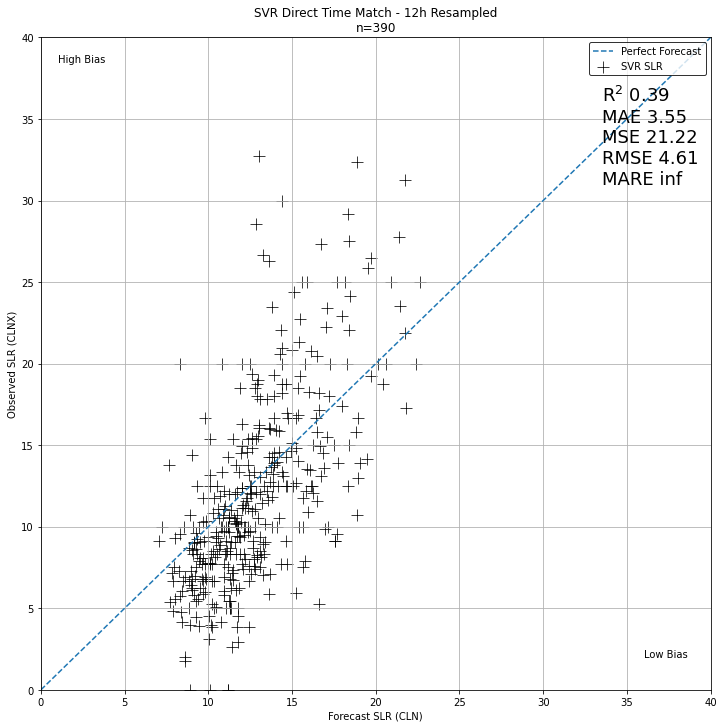

In [53]:
returned = verify_slr(svr, zcorr=True, tcorr=False)